In [1]:
# Final Project
# Ellis Lee A92029710
# Kevin Gonzalez A99090166
# Areli Lira A12125926 
# Khoa Bui A12641103
# Alina Chin A13358627
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
from sklearn import preprocessing

In [2]:
# Read suicide data.
data = pd.read_csv('suicide.csv')

In [3]:
# Drop country-year variable and rename columns. change gdp to numeric
data = data.drop(['country-year'],axis=1)
data.columns = ['country','year','sex','age','suicides','population',
              '100k_suicides','HDI','gdp','gdp_capita','generation']
data['gdp'] = pd.to_numeric([a['gdp'].replace(',','') for b,a in data.iterrows()])

In [4]:
# We want to find the percentage of the total population for a given group
data['population_est'] = data['population']/(data['gdp']/data['gdp_capita'])
data['total_suicide'] = data['100k_suicides'] * 1000

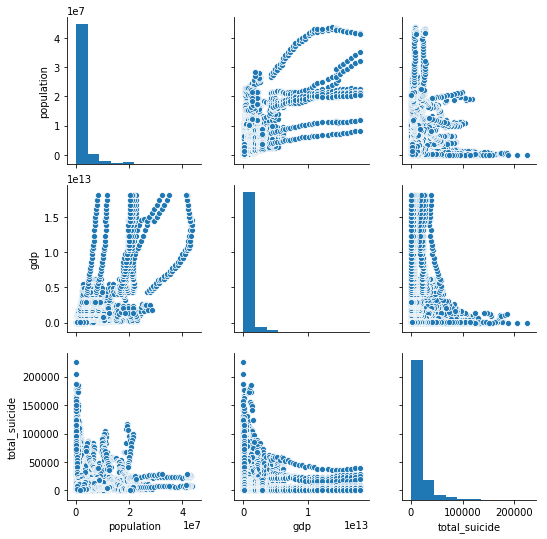

In [5]:
# will visualize only a couple variables
dat = data[['population','gdp','total_suicide']]
sns.pairplot(dat)

In [6]:
data.describe()

,year,suicides,population,100k_suicides,HDI,gdp,gdp_capita,population_est,total_suicide
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,2.782000e+04,27820.000000,27820.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,4.455810e+11,16866.464414,0.083357,12816.097412
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,1.453610e+12,18887.576472,0.040477,18961.511015
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,4.691962e+07,251.000000,0.000892,0.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,8.985353e+09,3447.000000,0.058681,920.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,4.811469e+10,9372.000000,0.082433,5990.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,2.602024e+11,24874.000000,0.109253,16620.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,1.812071e+13,126352.000000,0.309876,224970.000000


In [7]:
#Lets see how generation affects suicide rates
total = pd.DataFrame(data['100k_suicides'].groupby([data['year'],data['generation'],data['sex']]).mean()).reset_index()
#We need to fix some and add counts before (for millenials and gen z we need to add 0s before)
gens = ['Millenials','Generation Z','G.I. Generation']
for g in gens:
    for y in range(1985,2017,1):
        temp = total[(total['generation']==g) & (total['sex']=='male')]['year']
        if int(y) not in np.array(temp):
            total = total.append({'year':int(y),'generation':g,'sex':'male','100k_suicides':0} , ignore_index=True)
        temp = total[(total['generation']==g) & (total['sex']=='female')]['year']
        if int(y) not in np.array(temp):
            total = total.append({'year':int(y),'generation':g,'sex':'female','100k_suicides':0} , ignore_index=True)
#Boomers are missing 2010
totalm = (int(total[(total['generation']=='Boomers') & (total['year']==2009) & (total['sex']=='male')]['100k_suicides']) + 
          int(total[(total['generation']=='Boomers') & (total['year']==2011) & (total['sex']=='male')]['100k_suicides']))/2
total = total.append({'year':2010,'generation':'Boomers','sex':'male','100k_suicides':totalm} , ignore_index=True)
totalf = (int(total[(total['generation']=='Boomers') & (total['year']==2009) & (total['sex']=='female')]['100k_suicides']) + 
         int(total[(total['generation']=='Boomers') & (total['year']==2011) & (total['sex']=='female')]['100k_suicides']))/2
total = total.append({'year':2010,'generation':'Boomers','sex':'female','100k_suicides':totalf} , ignore_index=True)

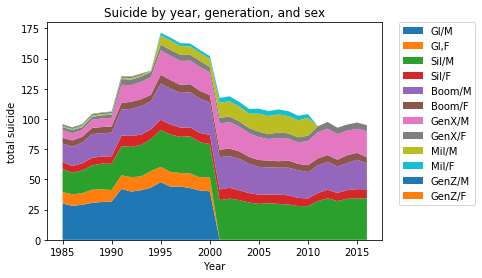

In [8]:
#Print total suciide by generation and gender
plt.stackplot(range(1985,2017),total[(total['sex']=='male') & (total['generation']=='G.I. Generation')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='G.I. Generation')]['100k_suicides'],
total[(total['sex']=='male') & (total['generation']=='Silent')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='Silent')]['100k_suicides'],
total[(total['sex']=='male') & (total['generation']=='Boomers')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='Boomers')]['100k_suicides'],
total[(total['sex']=='male') & (total['generation']=='Generation X')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='Generation X')]['100k_suicides'],
total[(total['sex']=='male') & (total['generation']=='Millenials')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='Millenials')]['100k_suicides'],
total[(total['sex']=='male') & (total['generation']=='Generation Z')]['100k_suicides'],
total[(total['sex']=='female') & (total['generation']=='Generation Z')]['100k_suicides'],)
plt.title('Suicide by year, generation, and sex')
plt.legend('Generation and sex')
plt.ylabel('total suicide')
plt.xlabel('Year')
plt.legend(['GI/M','GI,F','Sil/M','Sil/F','Boom/M','Boom/F',
            'GenX/M','GenX/F','Mil/M','Mil/F','GenZ/M','GenZ/F'],bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

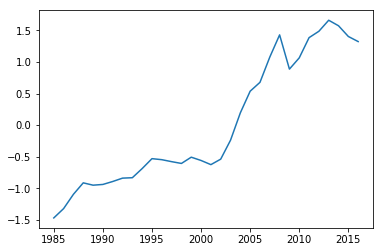

In [9]:
# Now lets see how much HDI, gdp_capita has changed over the years to see if maybe
# They correlate with ethe uptick of suicides in 1995-2000 and ~2010
dat = data[(data['generation']=='Silent') & (data['sex']=='male')]
#temp = pd.DataFrame(dat['gdp_capita'].groupby(dat['year']).mean()).reset_index()
#gdp_capita = (temp['gdp_capita']-np.mean(temp['gdp_capita']))/np.std(temp['gdp_capita'])
#year = total['year']
temp = pd.DataFrame(dat['gdp_capita'].groupby(dat['year']).mean()).reset_index()
gdp_capita1 = (temp['gdp_capita']-np.mean(temp['gdp_capita']))/np.std(temp['gdp_capita'])
plt.plot(range(1985,2017),gdp_capita1)

In [10]:
# There is a clear downtrend in suicide after the 2000s. Part of the reason is because
# Reporting increased after this.
mydict = {}
sums = {}
for i in range(1985,2017):
    mydict[str(i)] = len(dat[dat['year']==i]['gdp_capita'])
    sums[str(i)] = np.mean(dat[dat['year']==i]['gdp_capita'])
mydict   
sums

{'1985': 6091.229166666667,
 '1986': 7126.104166666667,
 '1987': 8712.592592592593,
 '1988': 9983.857142857143,
 '1989': 9725.038461538461,
 '1990': 9806.328125,
 '1991': 10132.9375,
 '1992': 10506.707692307693,
 '1993': 10553.584615384616,
 '1994': 11567.10294117647,
 '1995': 12669.346153846154,
 '1996': 12554.90909090909,
 '1997': 12336.142857142857,
 '1998': 12137.898734177215,
 '1999': 12832.192771084337,
 '2000': 12466.546511627907,
 '2001': 12005.579545454546,
 '2002': 12613.779069767443,
 '2003': 14716.186046511628,
 '2004': 17753.904761904763,
 '2005': 20155.964285714286,
 '2006': 21140.964705882354,
 '2007': 23943.43023255814,
 '2008': 26408.04705882353,
 '2009': 22607.91011235955,
 '2010': 23857.19318181818,
 '2011': 26100.918604651164,
 '2012': 26808.95061728395,
 '2013': 28032.675,
 '2014': 27420.141025641027,
 '2015': 26231.1935483871,
 '2016': 25665.125}

In [11]:
# Lets fit a linear model
total1 = pd.DataFrame(data['100k_suicides'].groupby([data['year'],data['generation'],data['sex']]).mean()).reset_index()
total2 = pd.get_dummies(total1)
#total2.drop(['sex_male','generation_Generation Z'], axis=1)
total2.columns = total2.columns.str.replace(' ', '')
total2.columns = total2.columns.str.replace('.', '')
total2.loc[:,'100k_suicides'] = (total2['100k_suicides']-np.mean(total2['100k_suicides']))/np.std(total2['100k_suicides'])
total2.columns = total2.columns.str.replace('100k_suicides', 'target')
a = 'target ~ ' + ' + '.join(total2.columns[2:])
outcome_1, predictors_1 = patsy.dmatrices(a,total2)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     173.6
Date:                Sat, 16 Mar 2019   Prob (F-statistic):           4.24e-92
Time:                        16:34:52   Log-Likelihood:                -189.79
No. Observations:                 292   AIC:                             393.6
Df Residuals:                     285   BIC:                             419.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [12]:
# The suicide rate is higher for older generaitons. Is this a cohort difference or just a time/age difference?
total1 = pd.DataFrame(data['100k_suicides'].groupby([data['year'],data['sex'],data['age']]).mean()).reset_index()
total2 = pd.get_dummies(total1)
total2.head()
total2.columns = total2.columns.str.replace(' ', '')
total2.columns = total2.columns.str.replace('.', '')
total2.columns = total2.columns.str.replace('-', 'to')
total2.columns = total2.columns.str.replace('years', '')
total2.columns = total2.columns.str.replace('+', '')
total2.loc[:,'100k_suicides'] = (total2['100k_suicides']-np.mean(total2['100k_suicides']))/np.std(total2['100k_suicides'])
total2.columns = total2.columns.str.replace('100k_suicides', 'target')
a = 'target ~ ' + ' + '.join(total2.columns[2:])
outcome_2, predictors_2 = patsy.dmatrices(a,total2)
mod_2 = sm.OLS(outcome_2,predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     297.0
Date:                Sat, 16 Mar 2019   Prob (F-statistic):          4.21e-139
Time:                        16:34:52   Log-Likelihood:                -207.88
No. Observations:                 382   AIC:                             429.8
Df Residuals:                     375   BIC:                             457.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0034      0.013     -0.262      0.7

In [13]:
#simple model total suicide and total gdp
a1,a2 = np.polyfit(data['gdp'],data['total_suicide'],1)

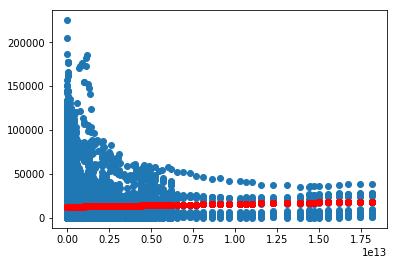

In [14]:
x_vals = data['gdp']
y_vals = a1 * x_vals + a2
plt.scatter(x_vals,data['total_suicide'])
plt.plot(x_vals,y_vals,'ro' )

In [15]:
#Looking at the above plot, we can see that suicides are high on low GDP, and overall lower at higher GDP.
#linear relationship is not the best, and this model is a poor predictor. Lets try using a second order

In [16]:
b1,b2,b3 = np.polyfit(data['gdp'],data['total_suicide'],2)

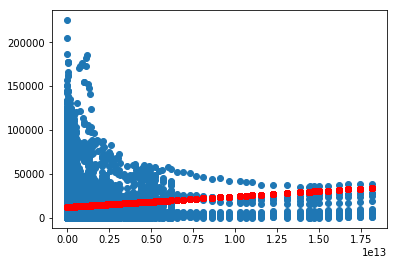

In [17]:
x_vals = data['gdp']
y_vals = b1 * np.power(x_vals,2) + b2 * x_vals + b3
plt.scatter(x_vals,data['total_suicide'])
plt.plot(x_vals,y_vals,'ro' )

In [18]:
#We also obtained a poor model here just by looking at it. I think this shows an overall trend, but not a good model

In [19]:
#simple model total suicide and total gdp
c1,c2 = np.polyfit(data['HDI'][~np.isnan(data['HDI'])],data['total_suicide'][~np.isnan(data['HDI'])],1)

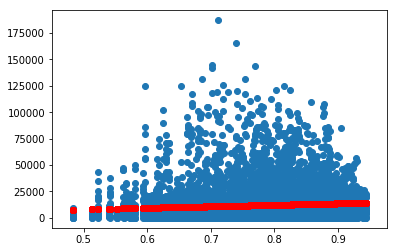

In [20]:
x_vals = data['HDI'][~np.isnan(data['HDI'])]
y_vals = c1 * x_vals + c2
plt.scatter(x_vals,data['total_suicide'][~np.isnan(data['HDI'])])
plt.plot(x_vals,y_vals,'ro' )

In [21]:
#So despite HDI going up, suicide is going up. why?
# The story is not as simple. and there is actually something important missing
# When we get the HDI, we actually have no idea of the population size. We are measuring with overall suicide
# and get no information abou thhe total population size. In fact, you may see that the line is going up with happiness
# index. This may be because happier countries tend to be bigger and not because happier countries have higher suicuide,
# lets actually see this

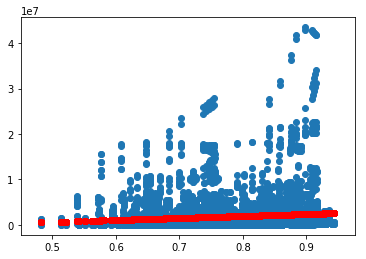

In [22]:
d1, d2 = np.polyfit(data['HDI'][~np.isnan(data['HDI'])],data['population'][~np.isnan(data['HDI'])],1)
x_vals = data['HDI'][~np.isnan(data['HDI'])]
y_vals = d1 * x_vals + d2
plt.scatter(x_vals,data['population'][~np.isnan(data['HDI'])])
plt.plot(x_vals,y_vals,'ro' )


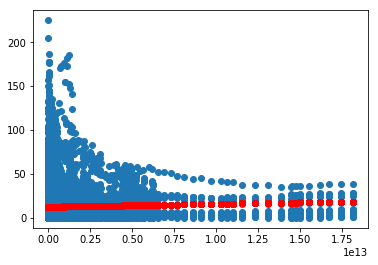

In [23]:
# Lets use suicide rate instead and see the differences.
b1,b2 = np.polyfit(data['gdp'],data['100k_suicides'],1)
x_vals = data['gdp']
y_vals = b1 * x_vals + b2
plt.scatter(x_vals,data['100k_suicides'])
plt.plot(x_vals,y_vals,'ro' )

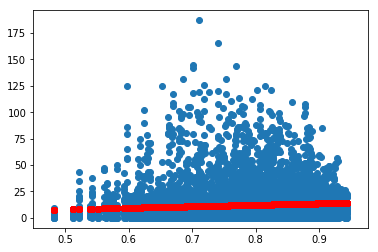

In [24]:
d1, d2 = np.polyfit(data['HDI'][~np.isnan(data['HDI'])],data['100k_suicides'][~np.isnan(data['HDI'])],1)
x_vals = data['HDI'][~np.isnan(data['HDI'])]
y_vals = d1 * x_vals + d2
plt.scatter(x_vals,data['100k_suicides'][~np.isnan(data['HDI'])])
plt.plot(x_vals,y_vals,'ro' )

In [25]:
#We get a somewhat better relationship, but not quite something good

In [26]:
# Grab other Data
dat = pd.read_csv('Data.csv')

SyntaxError: invalid syntax (<ipython-input-54-af41c9f3e498>, line 1)

In [ ]:
shortlist = ["Improved water source, urban (% of urban population with access)","Immunization, measles (% of children ages 12-23 months)",
             "School enrollment, primary (% gross)","Mortality rate, infant (per 1,000 live births)",
             "Adolescent fertility rate (births per 1,000 women ages 15-19)","Mortality rate, neonatal (per 1,000 live births)"]
replacements = ['water','measles','enrollment','mortality','adolescence','birth']
remove = ['Country Code','Indicator Code','1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', 
 '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983','1984']
dat1 = dat[dat['Indicator Name'].isin(shortlist)]
dat1 = dat1.drop(remove, axis=1)
dat1 = dat1[dat1.isnull().sum(axis=1)<10]

In [55]:
countrylist = np.unique([e for e in np.unique(dat1['Country Name']) if e in '\n'.join(np.unique(data['country']))])
for i, row in dat1.iterrows():
    string = row['Indicator Name']
    if row['Country Name'] in countrylist:
        val = replacements[shortlist.index(string)]
        for i in range(1985,2016):
            if str(val) not in data.columns:
                data[str(val)] = np.nan
            data.loc[((data['country'] == row['Country Name']) & (data['year']==int(i))),[str(val)]] = row[str(i)]


/Users/kevinice/anaconda2/envs/kevin/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kevinice/anaconda2/envs/kevin/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


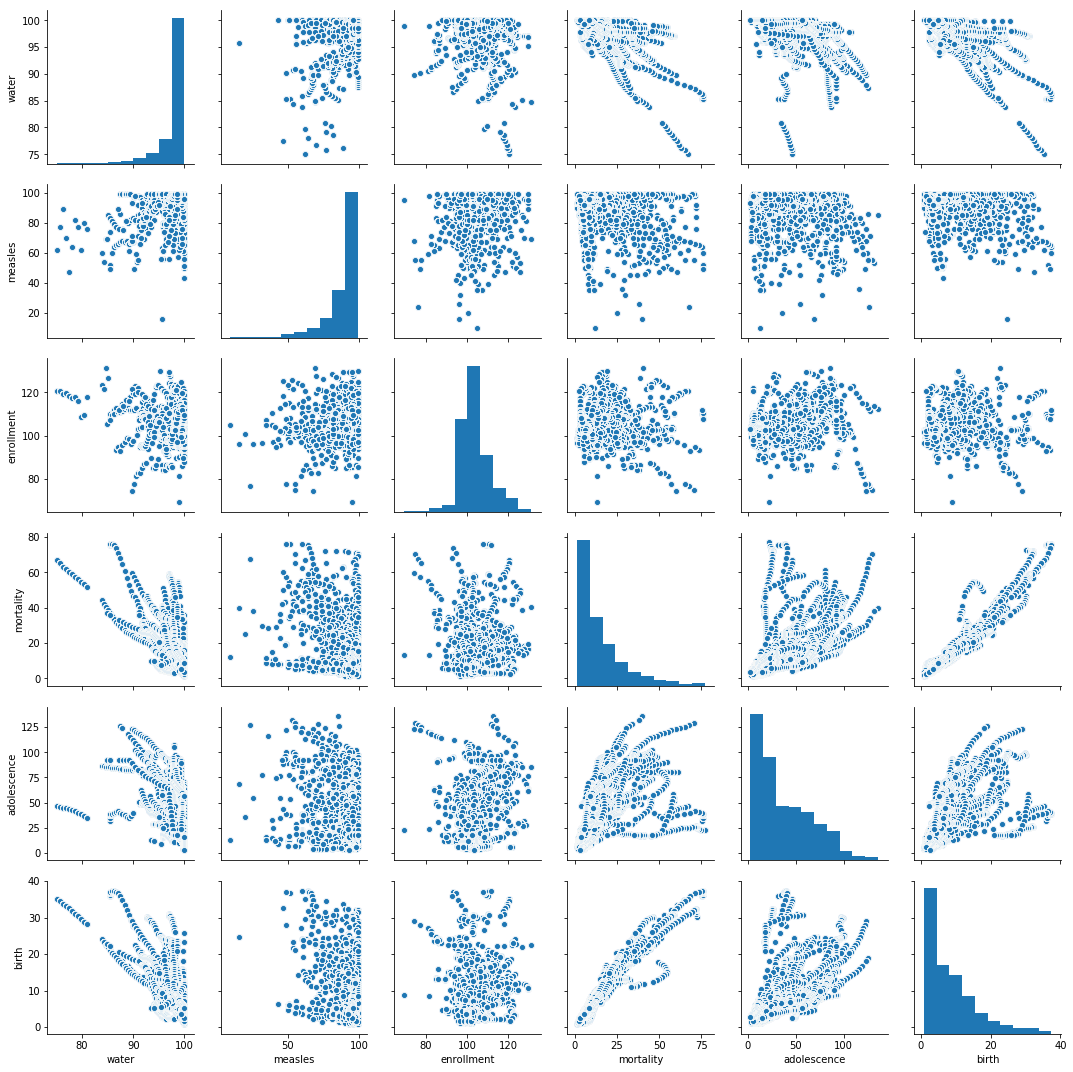

In [69]:
finaldat = data[replacements]
sns.pairplot(finaldat)

In [65]:
data.loc[:,'100k_suicides'] = (data['100k_suicides']-np.mean(data['100k_suicides']))/np.std(data['100k_suicides'])
data.columns = data.columns.str.replace('100k_suicides', 'target')
a = 'target ~' + ' + '.join(replacements)
outcome_3, predictors_3 = patsy.dmatrices(a,data)
mod_3 = sm.OLS(outcome_3,predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     106.7
Date:                Sat, 16 Mar 2019   Prob (F-statistic):          1.41e-132
Time:                        16:53:09   Log-Likelihood:                -24675.
No. Observations:               17340   AIC:                         4.936e+04
Df Residuals:                   17333   BIC:                         4.942e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.5301      0.395     -3.873      

102.786018    24
95.252937     12
97.519653     12
97.746841     12
97.747353     12
102.248978    12
106.246201    12
102.246513    12
93.253754     12
102.259903    12
101.236214    12
101.520271    12
101.520760    12
97.279778     12
97.491699     12
101.472359    12
102.717819    12
107.213470    12
97.211678     12
97.289223     12
104.290382    12
97.208504     12
69.207993     12
104.204422    12
105.041023    12
97.745232     12
97.262527     12
97.295570     12
120.487358    12
101.689812    12
              ..
98.865189     12
103.883110    12
98.887840     12
110.396980    12
98.103142     12
86.103432     12
97.631104     12
109.102608    12
98.442413     12
105.804710    12
100.444672    12
107.809799    12
104.438393    12
102.811279    12
98.438461     12
98.812401     12
98.564133     12
98.816040     12
98.816650     12
106.686028    12
98.930962     12
109.169182    12
107.836411    12
122.090942    12
107.410477    12
119.087257    12
98.587837     12
100.398773    

float